# Benchmark for Jensen Shannon

----

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon

## Data

> **Goal:** First we will <span style="color:cyan">**generate random data**</span> from two distributions. A "Category" column which will have Drift, and another "Number" column which will not have a difference in distribution

In [2]:
from generate_data import RandomDataGenerator

rdg = RandomDataGenerator()

data_range_min = 100
data_range_max = 1000000
range_col_min  = 2
range_col_max  = 20

# Obtenir la liste des nombres de données et de catégories
dfs = rdg.number_data(data_range_min, data_range_max, range_col_min, range_col_max)

print(f"Nombre de dataframes générés : {len(dfs)}")


Nombre de dataframes générés : 15


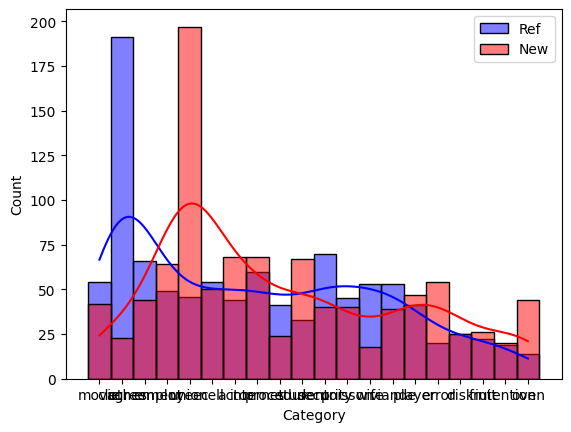

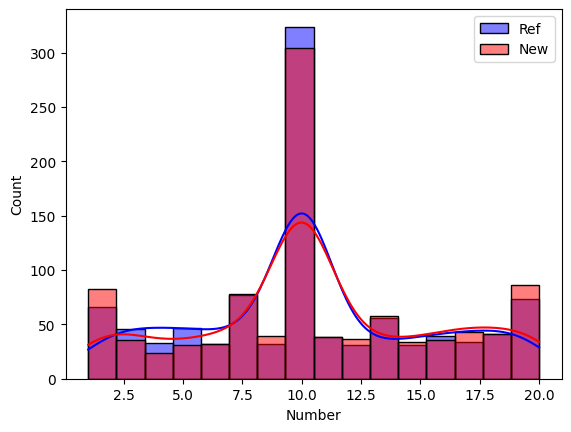

In [3]:
from charts import Graphics

charts = Graphics()

exemple_ref = dfs[5]['Data'][0]
exemple_new = dfs[5]['Data'][1]

charts.plot_hist(exemple_ref, exemple_new, 'Category')
charts.plot_hist(exemple_ref, exemple_new, 'Number')

## Drift

> **Goal:** <span style="color:cyan">**Detect a Drift**</span> on the distributions. But **only on the first column** and not the second

In [4]:
from functions import DriftFunctions

benchmark_prob = []
calculator     = DriftFunctions("js")

for df in dfs:    
    df_ref = df['Data'][0]
    df_new = df['Data'][1]
    
    for column in df_new.columns:
        probabilites       = calculator.get_proba(df_ref[column], df_new[column])
        drift_probability  = jensenshannon(probabilites[0], probabilites[1])
        is_drift           = calculator.detect_drift(drift_probability)
        
        if(df_new[column].dtype == np.float64 or df_new[column].dtype == np.int64):
            category    = "numeric"
        else:
            category    = "category"

        benchmark_prob.append({'Df': df['Stats'], 'column': column, 'type': category, 'js': round(drift_probability, 3), 'drift_js': is_drift})

benchmark_df_pob = pd.DataFrame(benchmark_prob)
benchmark_df_pob

,Df,column,type,js,drift_js
0,100_data_&_2_cat,Category,category,0.354,True
1,100_data_&_2_cat,Number,numeric,0.191,True
2,100_data_&_10_cat,Category,category,0.465,True
3,100_data_&_10_cat,Number,numeric,0.227,True
4,100_data_&_20_cat,Category,category,0.364,True
5,100_data_&_20_cat,Number,numeric,0.202,True
6,1000_data_&_2_cat,Category,category,0.556,True
7,1000_data_&_2_cat,Number,numeric,0.057,False
8,1000_data_&_10_cat,Category,category,0.269,True
9,1000_data_&_10_cat,Number,numeric,0.056,False


## Analyse

> **Goal:** We display <span style="color:cyan">**the course of the js**</span> to see the disturbances

In [5]:
test_ref = dfs[14]['Data'][0]
test_new = dfs[14]['Data'][1]

# Division en 4 parties égales
df_list_ref = np.array_split(test_ref, 1000)
df_list_new = np.array_split(test_new, 1000)

for test in df_list_ref[750:1000]:
    df_list_new.append(test)

for test in df_list_ref[500:750]:
    df_list_new.insert(0, test)

del df_list_ref[500:1000]
df_list_ref = pd.concat(df_list_ref)

In [6]:
js_time_cat = []
js_time_num = []

for batch in df_list_new:
    for column in batch.columns:
        
        probs       = calculator.get_proba(df_list_ref[column], batch[column])
        drift_probs = jensenshannon(probs[0], probs[1])
        
        if(batch[column].dtype == np.float64 or batch[column].dtype == np.int64):
            js_time_num.append(drift_probs)
        else:
            js_time_cat.append(drift_probs)
        

js_time_cat_df = pd.DataFrame(js_time_cat)
js_time_num_df = pd.DataFrame(js_time_num)

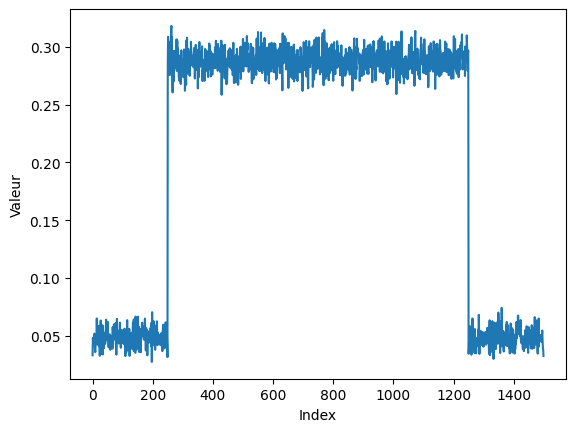

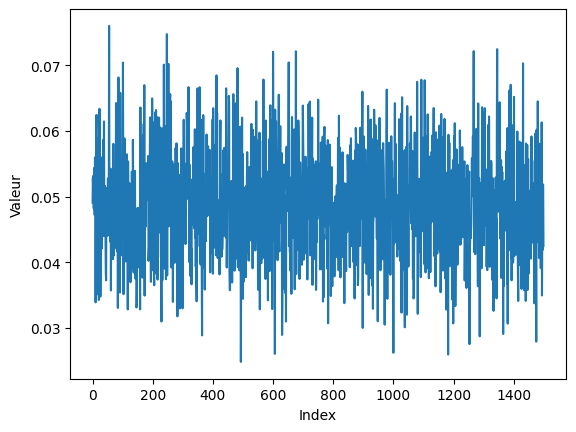

In [8]:
charts.plot_graph(js_time_cat_df)
charts.plot_graph(js_time_num_df)

In [9]:
from river import drift

adwin = drift.ADWIN()

for i, val in enumerate(js_time_cat_df.iterrows()):
    index, data = val
    _ = adwin.update(data[0])
    if adwin.drift_detected:
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 383, input value: (383, 0    0.278396
Name: 383, dtype: float64)
Change detected at index 1311, input value: (1311, 0    0.043578
Name: 1311, dtype: float64)


moyenne

découper la ref en plein de morceau

In [10]:
ref = dfs[14]['Data'][0]

col_cat = ref.loc[:, 'Category']
col_num = ref.loc[:, 'Number']


# Division en 4 parties égales
list_cat_moy = np.array_split(col_cat, 1000)
list_num_moy = np.array_split(col_num, 1000)

In [11]:
import random

# Créer une liste de tous les nombres de 1 à 100
liste_1_a_100 = list(range(0, 999))

# Créer une liste de toutes les combinaisons uniques de deux chiffres aléatoires
liste_combinaisons = [(a, b) for a in random.sample(liste_1_a_100, 100) for b in random.sample(liste_1_a_100, 100) if a != b]

In [12]:
avg_js_cat = []
avg_js_num = []

for batch in liste_combinaisons:
    probs_cat       = calculator.get_proba(list_cat_moy[batch[0]], list_cat_moy[batch[1]])
    probs_num       = calculator.get_proba(list_num_moy[batch[0]], list_num_moy[batch[1]])
    drift_probs_cat = jensenshannon(probs_cat[0], probs_cat[1])
    drift_probs_num = jensenshannon(probs_num[0], probs_num[1])
    avg_js_cat.append(drift_probs_cat)
    avg_js_num.append(drift_probs_num)

In [13]:
moyenne_cat = np.mean(avg_js_cat)
moyenne_num = np.mean(avg_js_num)

print(moyenne_cat, moyenne_num)

0.06860623368703608 0.06721378896207147
